In [1]:
from music21 import *
import copy

In [18]:
def mutate_melody(melody: stream.Part(), tonic: pitch.Pitch) -> stream.Part():
    '''
    given a melody, change it as appropriate. then return that melody.
    '''
    # staccato_short(melody, 0.9)
    accent_downbeat(melody)
    
    # double_note_frequency(melody, tonic)
    elevate_repeats(melody, tonic)
    
    chord_it(melody, tonic)
    grace_beginners(melody, tonic)

# Modifications to Melody

They are all intentionally short, and meant to be modular--that is, they can build on top of each other without causing much trouble.

## Articulation Modifications

In [3]:
def staccato_short(melody: stream.Part(), min_dur: float):
    '''
    make all sufficiently-short notes in the melody staccato.
    '''
    for n in melody[note.Note]:
        if n.quarterLength <= min_dur:
            n.articulations += [articulations.Staccato()]

In [4]:
def accent_downbeat(melody: stream.Part()):
    '''
    given a melody, accent every downbeat of the measures of the melody.
    '''
    for m in melody[stream.Measure]:
        for n in m[note.Note]:
            if n.offset == 0:
                n.articulations += [articulations.Accent()]

In [5]:
def grace_beginners(melody: stream.Part(), tonic: pitch.Pitch, offset_desired=2):
    '''
    given a melody, add a grace note to downbeat notes of measures
    '''
    sc = scale.MajorScale(tonic.name)
    for m in melody[stream.Measure]:
        for n in m[note.Note]:
            if n.offset == offset_desired:
                grace_start = note.Note(sc.nextPitch(n.nameWithOctave))
                grace = grace_start.getGrace()
                m.insert(0, grace)

In [6]:
n = note.Note('G4')
melody = stream.Part()
meas = stream.Measure()
meas.append(n)
melody.append(meas)
accent_downbeat(melody)
grace_beginners(melody, pitch.Pitch('C4'))
for no in melody[note.Note]:
    print(no, no.offset, no.quarterLength)

<music21.note.Note G> 0.0 1.0


## Involvement

The melody gets thicker...or less so.

In [7]:
def double_note_frequency(melody: stream.Part(), tonic: pitch.Pitch):
    '''
    given a melody, change each note to have two notes, each with double the frequency
    '''
    for m in melody[stream.Measure]:
        for n in m[note.Note]:
            n.quarterLength *= 0.5
            n1 = copy.deepcopy(n)
            off = n.offset + n.quarterLength
            m.insert(off, n1)

In [8]:
# test double_note_frequency
n = note.Note('G4')
melody = stream.Part()
meas = stream.Measure()
meas.append(n)
melody.append(meas)

double_note_frequency(melody, pitch.Pitch('G4'))
for n in melody[note.Note]:
    print(n, n.offset, n.quarterLength)

<music21.note.Note G> 0.0 0.5
<music21.note.Note G> 0.5 0.5


In [9]:
def elevate_repeats(melody: stream.Part(), tonic: pitch.Pitch, offset_mult=4):
    '''
    given a melody, for every note which starts a measure or a given offset
    multiplier (default 4: start of a 4/4 measure), change that note
    to have the next note up for the last 1/4 duration.
    
    Inspired by Country Gardens.
    
    C(4)-C(4) becomes C(3)-D(1)-C(4); parentheses illustrate durations.
    '''
    
    sc = scale.MajorScale(tonic.name)
    for m in melody[stream.Measure]:
        for n in m[note.Note]:
            if n.offset % offset_mult == 0:
                dur = n.quarterLength
                n.quarterLength = 0.75 * dur
                add_note = note.Note(sc.nextPitch(n.nameWithOctave))
                add_note.quarterLength = 0.25 * dur
                m.insert(n.offset + 0.75*dur, add_note)

In [10]:
melody = stream.Part()
meas = stream.Measure()
meas.append(note.Note('G4'))
meas.append(note.Note('G4'))
meas.append(note.Note('G4'))
meas.append(note.Note('G4'))
meas2 = stream.Measure()
meas2.append(note.Note('G4'))

melody.append(meas)
melody.append(meas2)
print(note.Note('G4').quarterLength)
melody
elevate_repeats(melody, pitch.Pitch('C4'))
for no in melody[note.Note]:
    print(no, no.offset)

1.0
<music21.note.Note G> 0.0
<music21.note.Note A> 0.75
<music21.note.Note G> 1.0
<music21.note.Note G> 2.0
<music21.note.Note G> 3.0
<music21.note.Note G> 0.0
<music21.note.Note A> 0.75


## Stacking

Keep the same notes, but thicken them.

In [11]:
def chord_it(melody: stream.Part(), tonic: pitch.Pitch, is_above=False, offset_mult=4):
    '''
    given a melody, take the first note of each measure and turn that into a chord
    '''
    sc = scale.MajorScale(tonic.name)
    for m in melody[stream.Measure]:
        for n in m[note.Note]:
            chord_notes = []
            if n.offset % offset_mult == 0:
                pitch_nums = [2, 4, 7]
                for i in range(3):
                    new_note = note.Note(sc.nextPitch(n.nameWithOctave, stepSize=pitch_nums[i]).nameWithOctave)
                    new_note.quarterLength = n.quarterLength
                    if not is_above:
                        new_note.octave -= 1 if new_note.name != n.name else 2
                    chord_notes.append(new_note)
                new_chord = chord.Chord(chord_notes)
                m.insert(n.offset, new_chord)

In [12]:
chord_it(melody, pitch.Pitch('C4'))

for no in melody[chord.Chord]:
    print(no, no.pitches, no.offset)

melody.show('midi')

<music21.chord.Chord B3 D4 G3> (<music21.pitch.Pitch B3>, <music21.pitch.Pitch D4>, <music21.pitch.Pitch G3>) 0.0
<music21.chord.Chord B3 D4 G3> (<music21.pitch.Pitch B3>, <music21.pitch.Pitch D4>, <music21.pitch.Pitch G3>) 0.0


In [13]:
n = note.Note('G6')

p = pitch.Pitch('G6')

p.octave

6

# Scaling the Hierarchy

Becuse parts cannot simply be concatenated to each other, we will need a few helper functions.

# Testing

We will test our function on pieces of different genres and see how they compare.

In [19]:
# primary test: Bach!

bach = corpus.parse('bwv66.6')

bach_melody = bach[1]

tonic = pitch.Pitch('A4')

for n in bach_melody[note.Note]:
    print(n, n.offset)
    
mutate_melody(bach_melody, tonic)
print('mutated')

for m in bach_melody[stream.Measure]:
    for n in bach_melody[chord.Chord]:
        print(n.pitches, m)

<music21.note.Note C#> 0.0
<music21.note.Note B> 0.5
<music21.note.Note A> 0.0
<music21.note.Note B> 1.0
<music21.note.Note C#> 2.0
<music21.note.Note E> 3.0
<music21.note.Note C#> 0.0
<music21.note.Note B> 1.0
<music21.note.Note A> 2.0
<music21.note.Note C#> 3.0
<music21.note.Note A> 0.0
<music21.note.Note B> 0.5
<music21.note.Note G#> 1.0
<music21.note.Note F#> 2.0
<music21.note.Note A> 3.0
<music21.note.Note B> 0.0
<music21.note.Note B> 1.0
<music21.note.Note F#> 2.0
<music21.note.Note E> 3.0
<music21.note.Note A> 0.0
<music21.note.Note B> 1.0
<music21.note.Note C#> 2.0
<music21.note.Note C#> 3.0
<music21.note.Note A> 0.0
<music21.note.Note B> 1.0
<music21.note.Note C#> 2.0
<music21.note.Note A> 3.0
<music21.note.Note G#> 0.0
<music21.note.Note F#> 1.0
<music21.note.Note G#> 2.0
<music21.note.Note F#> 0.0
<music21.note.Note F#> 2.0
<music21.note.Note F#> 3.0
<music21.note.Note F#> 0.0
<music21.note.Note F#> 1.0
<music21.note.Note E#> 1.5
<music21.note.Note F#> 2.0
mutated
(<music21.

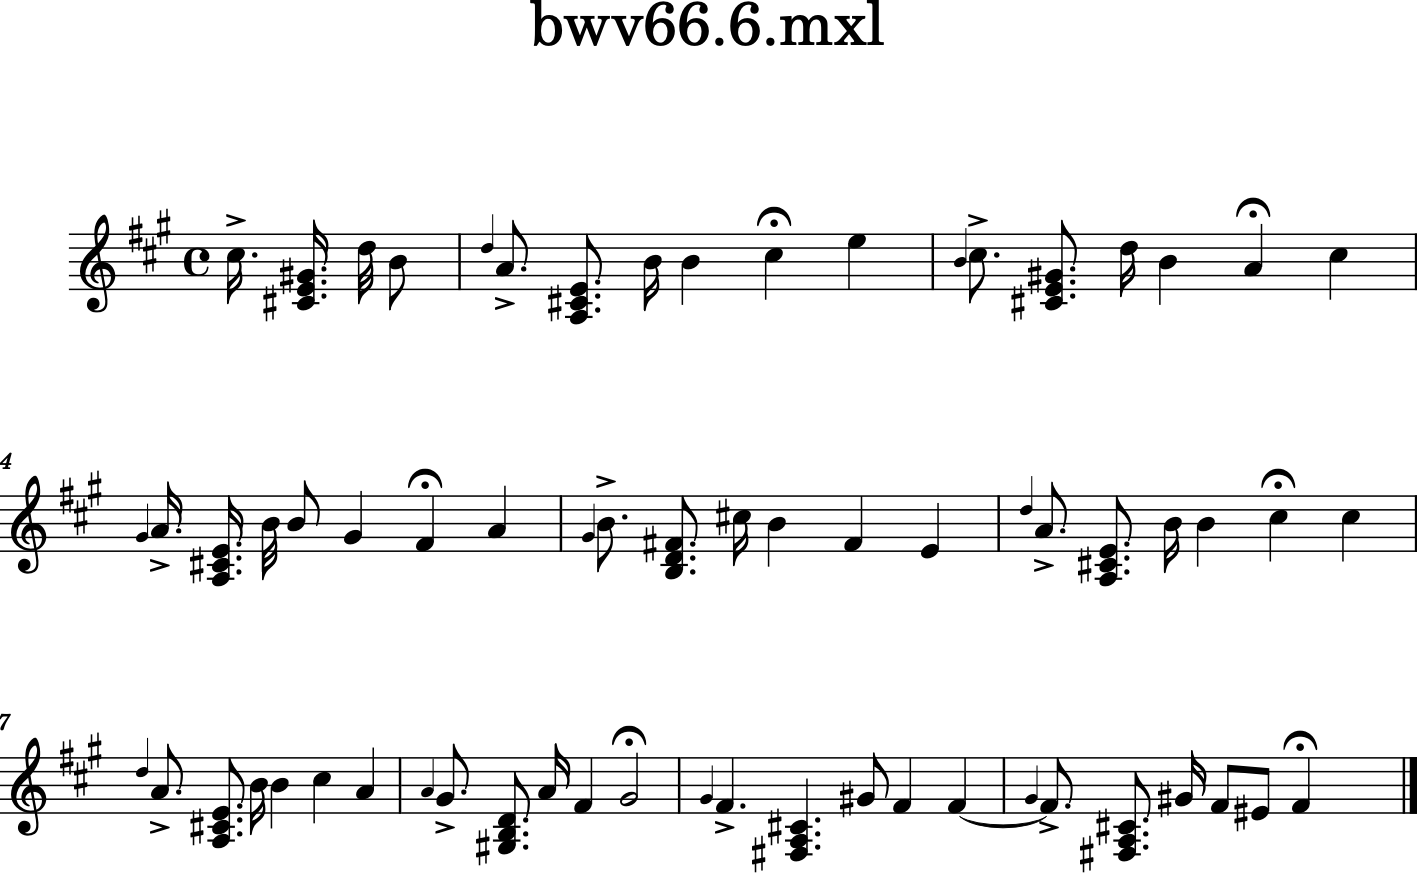

In [20]:
bach_melody.show()

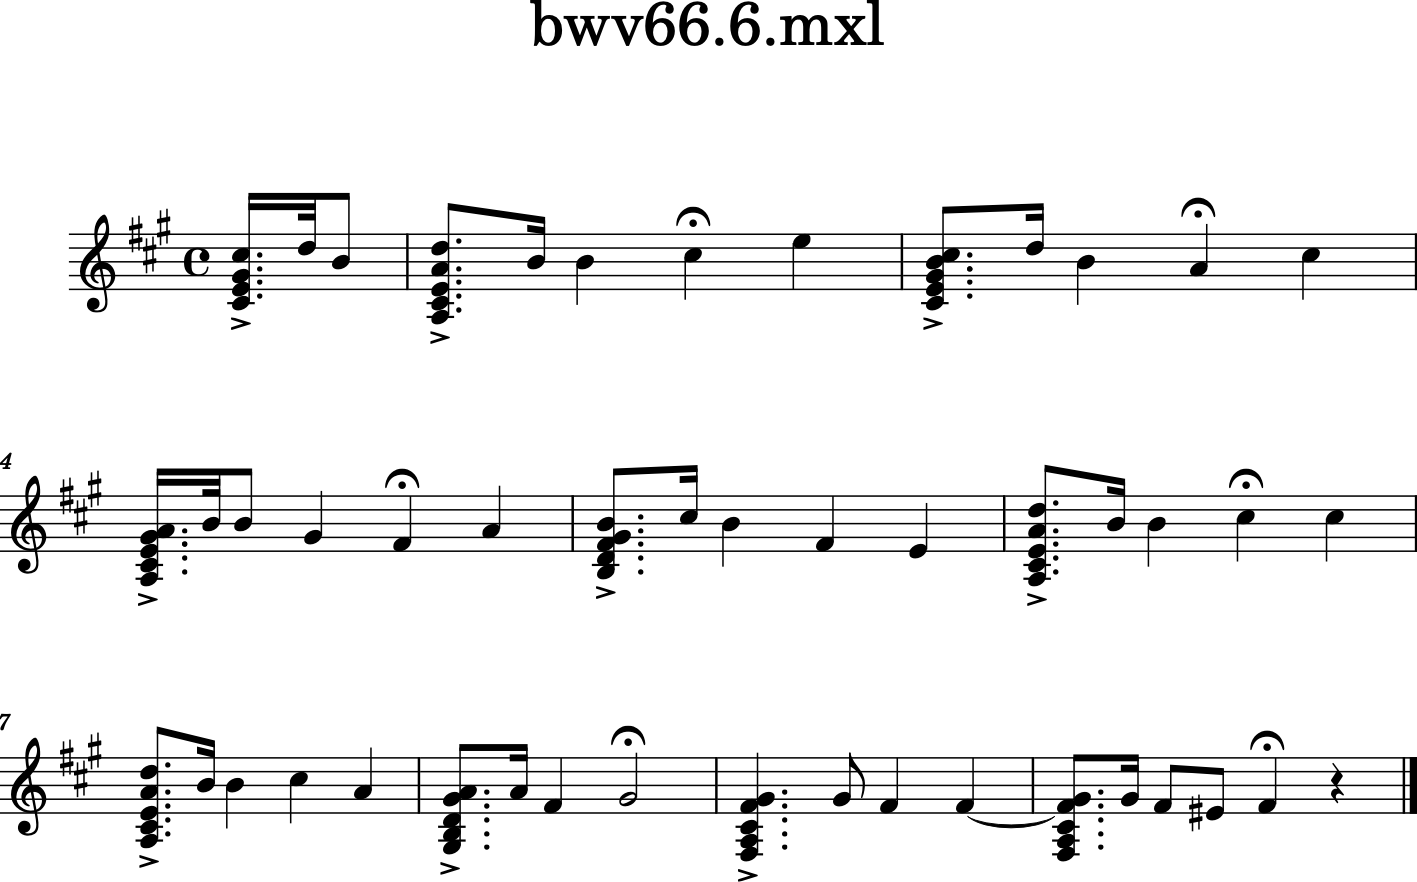

In [21]:
bach_melody.chordify().show()